In [1]:
# 导入工具包
%matplotlib inline  # 在plot时默认是嵌入到matplotlib里面
import random
import torch
from d2l import torch as d2l

In [4]:
# 构造一个简单的人造数据集
def synthetic_data(w, b, num_examples):
    """生成y=Xw+b+noise"""
    X = torch.normal(0,1,(num_examples, len(w)))  #均值为0，标准差为1
    y = torch.matmul(X,w)+b
    y += torch.normal(0,0.01, y.shape) # 添加随机噪声
    return X, y.reshape((-1,1))  #将y作为一个列向量返回

true_w = torch.tensor([2,-3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
print('features:',features[0], '\nlabel',labels[0])

features: tensor([-0.4009,  0.6733]) 
label tensor([1.1244])


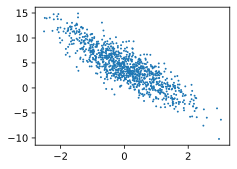

In [6]:
# 显示一下数据集
d2l.set_figsize()
d2l.plt.scatter(features[:,1].detach().numpy(),
               labels.detach().numpy(),1)

In [8]:
# 数据需要批量训练，构建一个提取批量数据函数
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))  # 生成每一个数据的标号
    random.shuffle(indices)  # 打乱标号
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i+batch_size, num_examples)]) # 使用min防止提取数据时超出
        yield features[batch_indices], labels[batch_indices]  # 使用yield不停的返回每一批数据
        
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-1.1331,  0.3272],
        [ 1.0194,  0.6074],
        [ 0.7307,  1.0902],
        [ 1.7948, -1.4975],
        [-0.5174,  0.4071],
        [-3.1606, -0.5715],
        [ 0.8944, -1.6782],
        [ 1.5117, -1.5467],
        [ 2.2591,  0.2600],
        [ 0.2844, -1.4975]]) 
 tensor([[ 0.8331],
        [ 4.1695],
        [ 1.9749],
        [12.8727],
        [ 1.7728],
        [-0.1917],
        [11.6966],
        [12.4664],
        [ 7.8274],
        [ 9.8576]])


In [15]:
# 定义模型，初始化参数
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad = True)  # 两个参数都需要计算梯度

# 定义线性回归模型
def linreg(X, w, b):
    return torch.matmul(X, w)+b


In [10]:
# 定义训练过程中的损失函数-使用均方损失
def squared_loss(y_hat, y):
    return (y_hat-y.reshape(y_hat.shape))**2/2  # 用reshape保持y与y_hat 维度一致

In [11]:
# 定义优化算法-小批量梯度下降
def sgd(params, lr, batch_size):
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad/batch_size     # 前面定义损失函数时没有求平均，这里除以batch_size
            param.grad.zero_()   # pytorch的机制中梯度不会清零，这里要手动清除

In [16]:
# 开始定义超参数和训练函数
lr = 0.03 #学习率
num_epochs = 3  #学习多少回合
net = linreg   # 线性回归模型
loss = squared_loss  # 均方损失函数

for epoch in range(num_epochs):
    for X,y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)   #这是一个批量的损失，l的形状是（batch_size，1）而不是一个标量
        l.sum().backward()  # 对l求和后再求梯度
        sgd([w,b], lr, batch_size)  # 使用梯度下降算法来更新参数
    
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)  # 训练完成后，计算误差
        print(f'epoch{epoch+1}, loss{float(train_l.mean()):f}')

epoch1, loss0.045473
epoch2, loss0.000200
epoch3, loss0.000049


In [17]:
# 输出训练完成后w,b的误差
print(f'w的误差: {true_w-w.reshape(true_w.shape)}')
print(f'b的误差: {true_b-b}')

w的误差: tensor([-0.0006, -0.0009], grad_fn=<SubBackward0>)
b的误差: tensor([0.0014], grad_fn=<RsubBackward1>)
